In [1]:
import matplotlib.pyplot as plt 
import numpy as np

from tqdm import tqdm
import time

import agent
import integrate
import kalman_filter

In [2]:
# Define IMU refresh rate and corresponding wait time
imu_rate  = 60
imu_per   = 1 / imu_rate

# Define GNSS refresh rate and corresponding wait time
gnss_rate = 60
gnss_per  = 1 / gnss_rate

# Time for which to save results 
save_time = 30

# List length required for saving data
imu_len   = save_time * imu_rate
gnss_len  = save_time * gnss_rate

imu_std_dev_a = 0.1
imu_std_dev_g = 0
gnss_std_dev  = 1e-5

In [3]:
# Create agent
a = agent.agent()
# a.client.reload_world()

In [4]:
# Spawn vehicle and sensors
a.spawn_vehicle()

 Vehicle model : volkswagen t2
 Spawning vehicle at location : -9, 179, 0 (random generation)


In [5]:
# Reset data memory for sensors
imu_list  = []
gnss_list = []
real_pos  = []

def imu_listener(data):
    
    if(len(imu_list) < imu_len):
        accel = data.accelerometer
        gyro  = data.gyroscope
        
        imu_list.append(((accel.x, accel.y, accel.z), (gyro.x, gyro.y, gyro.z), data.timestamp))

def gnss_listener(data):
    if(len(gnss_list) < gnss_len):
        x, y, z = a.gnss_to_xyz(data)
        rpos  = data.transform.location

        gnss_list.append(((x, y, z), data.timestamp))
        real_pos.append(((rpos.x, rpos.y, rpos.z), data.timestamp))


# Spawn sensors and set autopilot
a.spawn_imu(imu_per, imu_std_dev_a, imu_std_dev_g)
a.imu_reg_callback(imu_listener)
a.spawn_gnss(gnss_listener, gnss_per, gnss_std_dev)

a.vehicle.set_autopilot(True)

783 of 1800


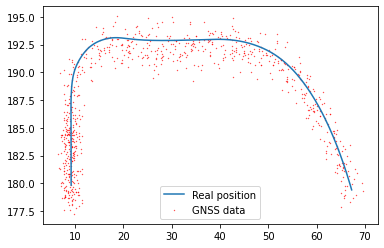

In [17]:
print("%d of %d"%(len(gnss_list), gnss_len))

rpos_xy = np.asarray([(x[0][0], x[0][1]) for x in real_pos])
gnss_xy = np.asarray([(x[0][0], x[0][1]) for x in gnss_list])

plt.scatter(-gnss_xy[:,0], gnss_xy[:,1], 0.1, label="GNSS data", color='red')
plt.plot(-rpos_xy[:,0], rpos_xy[:,1], label="Real position")
plt.legend()
plt.show()

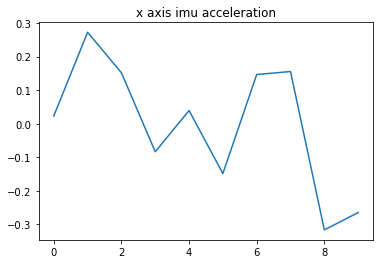

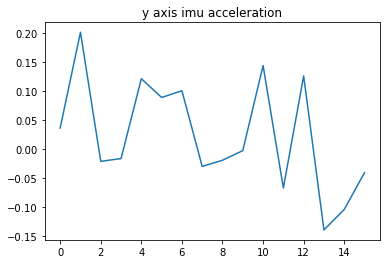

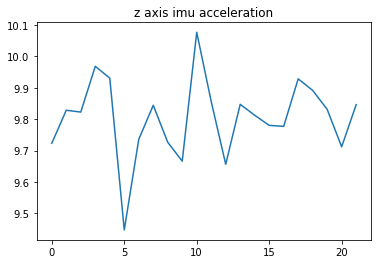

In [7]:
plt.plot([x[0][0] for x in imu_list])
plt.title('x axis imu acceleration')
plt.show()
plt.plot([x[0][1] for x in imu_list])
plt.title('y axis imu acceleration')
plt.show()
plt.plot([x[0][2] for x in imu_list])
plt.title('z axis imu acceleration')
plt.show()

In [8]:
init_vel    = a.vehicle.get_velocity()
init_loc    = a.vehicle.get_location()
init_rot    = a.vehicle.get_transform().rotation
timestamp   = a.world.get_snapshot().timestamp.elapsed_seconds

init_state = np.asarray([init_loc.x, init_loc.y, init_rot.yaw * np.pi /180, init_vel.x, init_vel.y]).reshape(5,1)
int_obj = integrate.imu_integrate(init_state, timestamp)

int_rvel_list  = []
int_rpos_list  = []
int_ryaw_list  = []

def imu_int_listener(data):
    if(len(int_rvel_list) < imu_len):
        rvel    = a.vehicle.get_velocity()
        rloc    = a.vehicle.get_location()
        rrot    = a.vehicle.get_transform().rotation
        timestamp   = data.timestamp

        int_rvel_list.append(((rvel.x, rvel.y), timestamp))
        int_rpos_list.append(((rloc.x, rloc.y), timestamp))
        int_ryaw_list.append((rrot.yaw * np.pi / 180, timestamp))

        yaw_vel = data.gyroscope.z
        accel_x = data.accelerometer.x
        accel_y = data.accelerometer.y

        int_obj.update(np.asarray([accel_x, accel_y, yaw_vel]).reshape(3,1), timestamp)

a.imu_reg_callback(imu_int_listener)

In [9]:
init_vel    = a.vehicle.get_velocity()
init_loc    = a.vehicle.get_location()
init_rot    = a.vehicle.get_transform().rotation
timestamp   = a.world.get_snapshot().timestamp.elapsed_seconds

init_state = np.asarray([init_loc.x, init_loc.y, init_rot.yaw * np.pi /180, init_vel.x, init_vel.y]).reshape(5,1)
kal_obj = kalman_filter.imu_integrate(init_state, timestamp, np.square(imu_std_dev_a), np.square(imu_std_dev_g))

kal_rvel_list  = []
kal_rpos_list  = []
kal_ryaw_list  = []

def imu_kal_listener(data):
    if(len(kal_rvel_list) < imu_len):
        rvel    = a.vehicle.get_velocity()
        rloc    = a.vehicle.get_location()
        rrot    = a.vehicle.get_transform().rotation
        timestamp   = data.timestamp

        kal_rvel_list.append(((rvel.x, rvel.y), timestamp))
        kal_rpos_list.append(((rloc.x, rloc.y), timestamp))
        kal_ryaw_list.append((rrot.yaw * np.pi / 180, timestamp))

        yaw_vel = data.gyroscope.z
        accel_x = data.accelerometer.x
        accel_y = data.accelerometer.y
        
        kal_obj.update(np.asarray([accel_x, accel_y, yaw_vel]).reshape(3,1), timestamp)

a.imu_reg_callback(imu_kal_listener)

896 of 1800


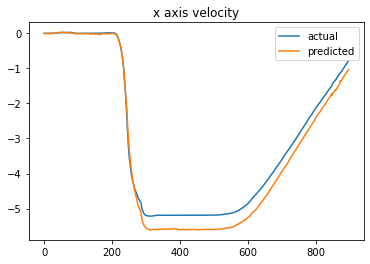

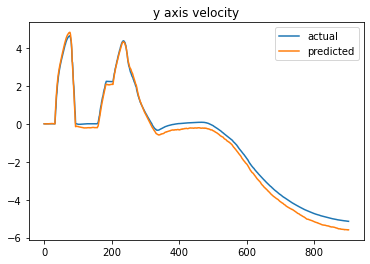

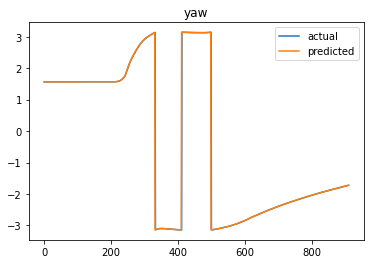

In [18]:
print("%d of %d"%(len(int_rvel_list), imu_len))

plt.plot([x[0][0] for x in int_rvel_list], label='actual')
plt.plot([x[0][3,0] for x in int_obj.states], label='predicted')
plt.title('x axis velocity')
plt.legend()
plt.show()

plt.plot([x[0][1] for x in int_rvel_list], label='actual')
plt.plot([x[0][4,0] for x in int_obj.states], label='predicted')
plt.title('y axis velocity')
plt.legend()
plt.show()

plt.plot([x[0] for x in int_ryaw_list], label='actual')
plt.plot([x[0][2,0] for x in int_obj.states], label='predicted')
plt.title('yaw')
plt.legend()
plt.show()

1800 of 1800


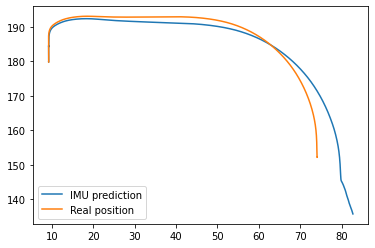

Time : 589.97 to 633.04
Time : 589.97 to 633.04


In [25]:
print("%d of %d"%(len(int_rvel_list), imu_len))

rpos_xy = np.asarray([(x[0][0], x[0][1]) for x in int_rpos_list])
gnss_xy = np.asarray([(x[0][0], x[0][1]) for x in int_obj.states])

plt.plot(-gnss_xy[:,0], gnss_xy[:,1], label="IMU prediction")
plt.plot(-rpos_xy[:,0], rpos_xy[:,1], label="Real position")
plt.legend()
plt.show()

print("Time : %.2f to %.2f"%(int_rpos_list[0][1], int_rpos_list[-1][1]))
print("Time : %.2f to %.2f"%(int_obj.states[0][1], int_obj.states[-1][1]))

1800 of 1800


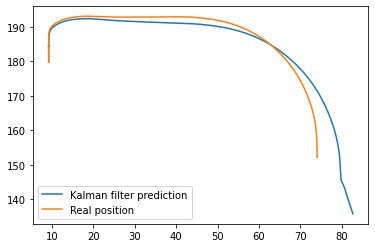

Time : 589.99 to 633.06
Time : 589.99 to 633.06


In [28]:
print("%d of %d"%(len(kal_rvel_list), imu_len))

k_rpos_xy = np.asarray([(x[0][0], x[0][1]) for x in kal_rpos_list])
k_pred_xy = np.asarray([(x[0][0], x[0][1]) for x in kal_obj.states])

plt.plot(-k_pred_xy[:,0], k_pred_xy[:,1,0], label="Kalman filter prediction")
plt.plot(-k_rpos_xy[:,0], k_rpos_xy[:,1], label="Real position")
plt.legend()
plt.show()

print("Time : %.2f to %.2f"%(kal_rpos_list[0][1], kal_rpos_list[-1][1]))
print("Time : %.2f to %.2f"%(kal_obj.states[0][1], kal_obj.states[-1][1]))

In [30]:
print(kal_obj.covar)

[[1.86431157e+03 0.00000000e+00 0.00000000e+00 4.33165075e+01
  0.00000000e+00]
 [0.00000000e+00 1.86431157e+03 0.00000000e+00 0.00000000e+00
  4.33165075e+01]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [4.33165075e+01 0.00000000e+00 0.00000000e+00 1.01041877e+00
  0.00000000e+00]
 [0.00000000e+00 4.33165075e+01 0.00000000e+00 0.00000000e+00
  1.01041877e+00]]


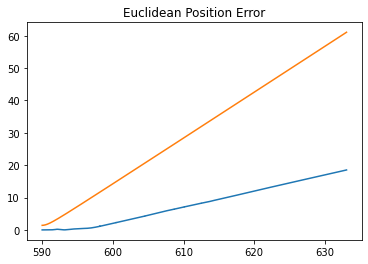

In [37]:
error = np.sqrt(np.sum(np.square(k_rpos_xy-k_pred_xy[:,:,0]),axis=1))
var   = np.sqrt(np.sum([(k[0][0][0], k[0][1][1]) for k in kal_obj.covars], axis=1))

plt.plot([x[1] for x in kal_rpos_list], error, label="error")
plt.plot([x[1] for x in kal_obj.covars], var, label="standard deviation")
plt.title("Euclidean Position Error")
plt.show()